# 🧼 Análisis de Texto y Modelado Temático - CFPB

Limpieza de texto, TF-IDF con n-gramas y clustering para descubrir temas latentes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Usar new_df ya preparado
new_df = pd.read_csv('new_dataset.csv')
print(f"Dataset: {len(new_df):,} registros")
print(f"Narrativas disponibles: {new_df['consumer_complaint_narrative'].notna().sum():,}")

Dataset: 8,509,423 registros
Narrativas disponibles: 2,715,202


## 1. Preparación y Limpieza de Texto

In [4]:
# Filtrar solo registros con narrativa
text_df = new_df[new_df['consumer_complaint_narrative'].notna()].copy()
print(f"Registros con narrativa: {len(text_df):,}")

# Tomar muestra para análisis eficiente
sample_size = min(10000, len(text_df))
text_sample = text_df.sample(n=sample_size, random_state=42)
print(f"Muestra para análisis: {len(text_sample):,}")

Registros con narrativa: 2,715,202
Muestra para análisis: 10,000


In [5]:
def clean_text(text):
    """Limpieza básica de texto"""
    if pd.isna(text):
        return ""
    # Convertir a minúsculas
    text = str(text).lower()
    # Remover caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remover espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicar limpieza
text_sample['clean_narrative'] = text_sample['consumer_complaint_narrative'].apply(clean_text)

# Filtrar textos muy cortos
text_sample = text_sample[text_sample['clean_narrative'].str.len() > 20]
print(f"Textos después de limpieza: {len(text_sample):,}")

Textos después de limpieza: 9,997


## 2. TF-IDF con N-gramas

In [6]:
# TF-IDF con unigramas y bigramas
tfidf = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=5,
    max_df=0.8
)

tfidf_matrix = tfidf.fit_transform(text_sample['clean_narrative'])
feature_names = tfidf.get_feature_names_out()

print(f"Matriz TF-IDF: {tfidf_matrix.shape}")
print(f"Características extraídas: {len(feature_names)}")

Matriz TF-IDF: (9997, 1000)
Características extraídas: 1000


In [7]:
# Top frases clave por TF-IDF
tfidf_scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_scores.argsort()[-20:][::-1]
top_features = [(feature_names[i], tfidf_scores[i]) for i in top_indices]

print("🔑 TOP 20 FRASES CLAVE (TF-IDF):")
for i, (feature, score) in enumerate(top_features, 1):
    print(f"{i:2d}. {feature}: {score:.2f}")

🔑 TOP 20 FRASES CLAVE (TF-IDF):
 1. xxxx: 2152.86
 2. xxxx xxxx: 1454.27
 3. credit: 646.28
 4. account: 526.98
 5. report: 484.88
 6. information: 405.84
 7. credit report: 366.90
 8. consumer: 348.91
 9. reporting: 344.70
10. accounts: 340.94
11. xxxxxxxx: 334.82
12. debt: 257.62
13. payment: 247.78
14. usc: 227.90
15. company: 212.97
16. section: 204.67
17. late: 199.82
18. card: 197.41
19. bank: 196.83
20. did: 193.34


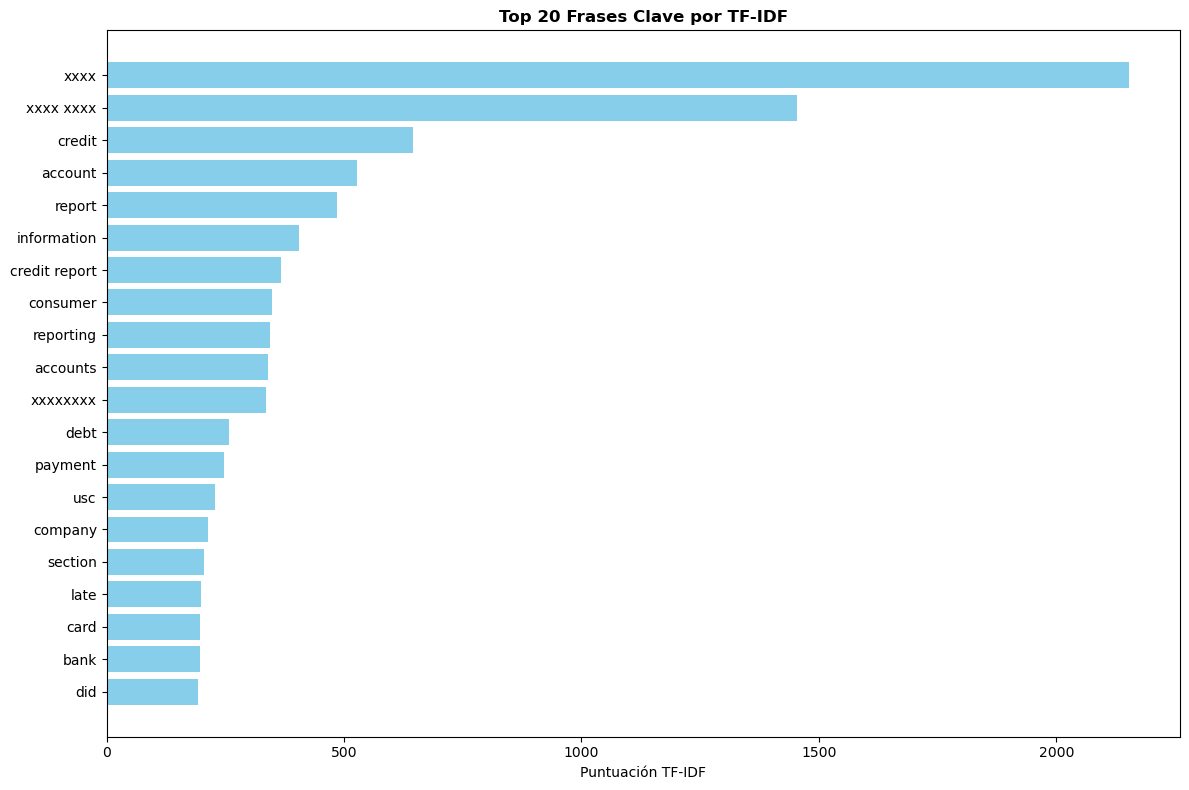

In [8]:
# Visualización de top frases clave
top_20_features = [f[0] for f in top_features]
top_20_scores = [f[1] for f in top_features]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_20_features)), top_20_scores, color='skyblue')
plt.yticks(range(len(top_20_features)), top_20_features)
plt.xlabel('Puntuación TF-IDF')
plt.title('Top 20 Frases Clave por TF-IDF', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Clustering K-Means para Temas Latentes

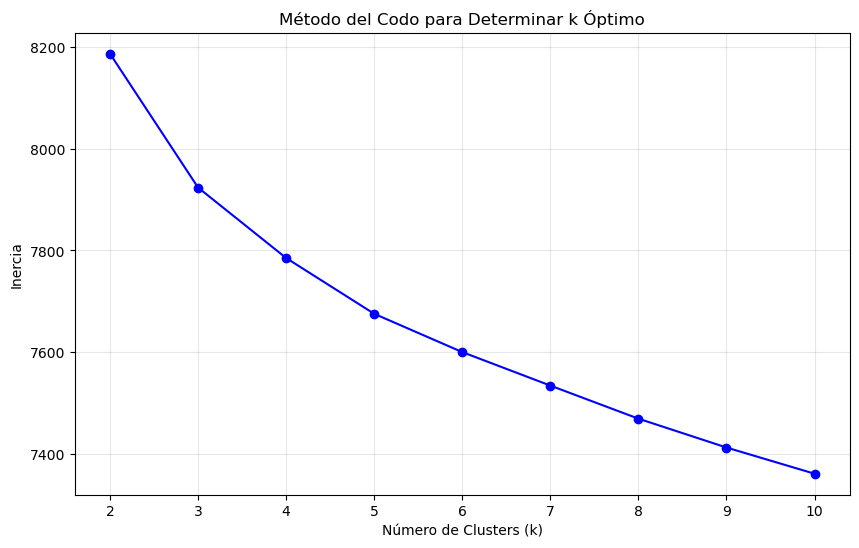

Inercias por k: {2: 8186.5209838401715, 3: 7923.599096738612, 4: 7785.213904936517, 5: 7675.634497786421, 6: 7600.408851093198, 7: 7534.618873931271, 8: 7469.628714449213, 9: 7412.974177465908, 10: 7361.487937723594}


In [9]:
# Determinar número óptimo de clusters
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar k Óptimo')
plt.grid(True, alpha=0.3)
plt.show()

print("Inercias por k:", dict(zip(k_range, inertias)))

In [10]:
# Aplicar K-Means con k=5
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_matrix)

# Agregar clusters al DataFrame
text_sample['cluster'] = clusters

print(f"Clustering completado con {n_clusters} clusters")
print("\nDistribución de clusters:")
print(text_sample['cluster'].value_counts().sort_index())

Clustering completado con 5 clusters

Distribución de clusters:
cluster
0    2894
1    2282
2     541
3    2849
4    1431
Name: count, dtype: int64


## 4. Análisis de Temas por Cluster

In [11]:
# Extraer términos más importantes por cluster
def get_top_terms_per_cluster(kmeans_model, feature_names, n_terms=10):
    cluster_terms = {}
    
    for i, centroid in enumerate(kmeans_model.cluster_centers_):
        # Obtener índices de términos más importantes
        top_indices = centroid.argsort()[-n_terms:][::-1]
        top_terms = [feature_names[idx] for idx in top_indices]
        cluster_terms[i] = top_terms
    
    return cluster_terms

cluster_terms = get_top_terms_per_cluster(kmeans, feature_names, 10)

print("🎯 TEMAS PRINCIPALES POR CLUSTER:")
print("=" * 50)
for cluster_id, terms in cluster_terms.items():
    print(f"\nCluster {cluster_id} ({text_sample[text_sample['cluster']==cluster_id].shape[0]} documentos):")
    print(f"Términos clave: {', '.join(terms[:5])}")
    print(f"Todos los términos: {', '.join(terms)}")

🎯 TEMAS PRINCIPALES POR CLUSTER:

Cluster 0 (2894 documentos):
Términos clave: credit, report, credit report, accounts, information
Todos los términos: credit, report, credit report, accounts, information, xxxx, reporting, consumer, inaccurate, identity

Cluster 1 (2282 documentos):
Términos clave: xxxx, xxxx xxxx, account, credit, xxxxxxxx
Todos los términos: xxxx, xxxx xxxx, account, credit, xxxxxxxx, report, debt, information, reporting, credit report

Cluster 2 (541 documentos):
Términos clave: section, usc, section states, usc section, consumer
Todos los términos: section, usc, section states, usc section, consumer, states, xxxx, consumer reporting, reporting, reporting agency

Cluster 3 (2849 documentos):
Términos clave: xxxx, account, payment, bank, card
Todos los términos: xxxx, account, payment, bank, card, xxxxxxxx, late, loan, payments, credit

Cluster 4 (1431 documentos):
Términos clave: xxxx, xxxx xxxx, xxxxxxxx, credit, xxxx xxxxxxxx
Todos los términos: xxxx, xxxx xxxx, x

In [13]:
# Análisis de productos por cluster
cluster_product_analysis = text_sample.groupby(['cluster', 'product']).size().unstack(fill_value=0)

print("📊 PRODUCTOS MÁS COMUNES POR CLUSTER:")
for cluster_id in range(n_clusters):
    top_products = cluster_product_analysis.loc[cluster_id].nlargest(3)
    print(f"\nCluster {cluster_id}:")
    for product, count in top_products.items():
        print(f"  • {product[:50]}...: {count} quejas")

📊 PRODUCTOS MÁS COMUNES POR CLUSTER:

Cluster 0:
  • Credit reporting or other personal consumer report...: 1571 quejas
  • Credit reporting, credit repair services, or other...: 973 quejas
  • Debt collection...: 248 quejas

Cluster 1:
  • Credit reporting, credit repair services, or other...: 754 quejas
  • Credit reporting or other personal consumer report...: 527 quejas
  • Debt collection...: 346 quejas

Cluster 2:
  • Credit reporting or other personal consumer report...: 277 quejas
  • Credit reporting, credit repair services, or other...: 248 quejas
  • Debt collection...: 10 quejas

Cluster 3:
  • Debt collection...: 413 quejas
  • Checking or savings account...: 377 quejas
  • Credit reporting, credit repair services, or other...: 343 quejas

Cluster 4:
  • Credit reporting or other personal consumer report...: 605 quejas
  • Credit reporting, credit repair services, or other...: 594 quejas
  • Debt collection...: 95 quejas


## 5. Visualización de Clusters

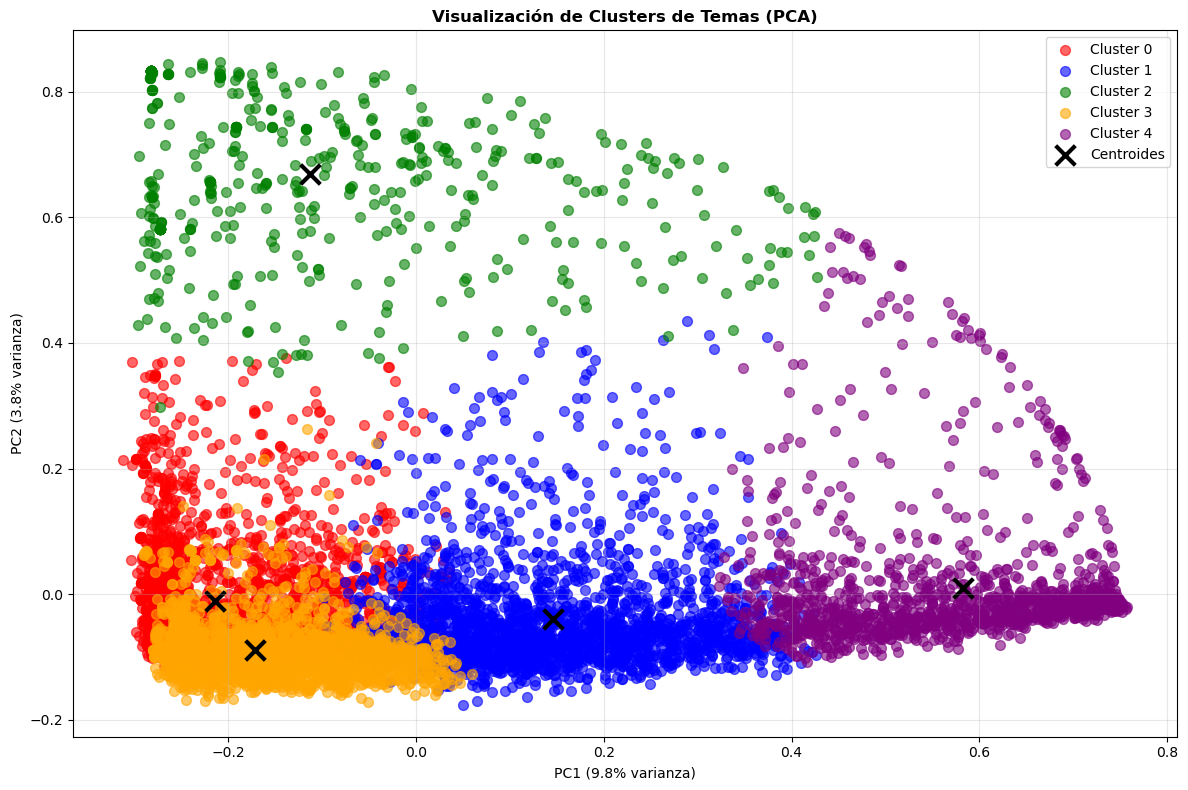

Varianza explicada total: 13.6%


In [14]:
# Reducción de dimensionalidad con PCA para visualización
pca = PCA(n_components=2, random_state=42)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())

# Gráfico de dispersión de clusters
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(n_clusters):
    cluster_points = tfidf_2d[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=colors[i], label=f'Cluster {i}', alpha=0.6, s=50)

# Centroides
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
           c='black', marker='x', s=200, linewidths=3, label='Centroides')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.title('Visualización de Clusters de Temas (PCA)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Varianza explicada total: {pca.explained_variance_ratio_.sum():.1%}")

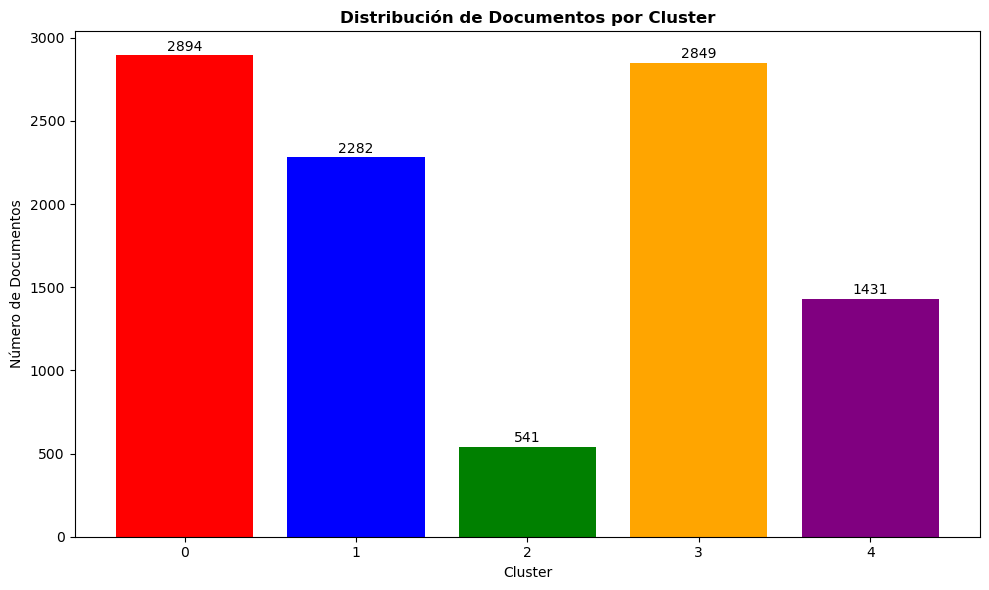

In [15]:
# Distribución de clusters
cluster_counts = text_sample['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors[:n_clusters])
plt.xlabel('Cluster')
plt.ylabel('Número de Documentos')
plt.title('Distribución de Documentos por Cluster', fontweight='bold')

# Agregar etiquetas en las barras
for bar, count in zip(bars, cluster_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. Ejemplos de Narrativas por Cluster

In [17]:
# Mostrar ejemplos de narrativas por cluster
print("📝 EJEMPLOS DE NARRATIVAS POR CLUSTER:")
print("=" * 60)

for cluster_id in range(n_clusters):
    cluster_docs = text_sample[text_sample['cluster'] == cluster_id]
    sample_docs = cluster_docs.sample(n=min(2, len(cluster_docs)), random_state=42)
    
    print(f"\n🎯 CLUSTER {cluster_id} - Términos clave: {', '.join(cluster_terms[cluster_id][:3])}")
    print("-" * 40)
    
    for idx, (_, row) in enumerate(sample_docs.iterrows(), 1):
        narrative = row['consumer_complaint_narrative']
        product = row['product']
        print(f"Ejemplo {idx} ({product[:30]}...):")
        print(f"{narrative[:200]}...\n")

📝 EJEMPLOS DE NARRATIVAS POR CLUSTER:

🎯 CLUSTER 0 - Términos clave: credit, report, credit report
----------------------------------------
Ejemplo 1 (Credit reporting or other pers...):
I am writing to file a formal complaint regarding the inaccurate reporting of a late payment on my credit report by credit bureaus. The presence of this late payment inaccurately reflects my payment h...

Ejemplo 2 (Credit reporting or other pers...):
XXXXredit Collections on my Equifax Credit Report is being reported inaccurately. Account was paid in full with original creditor and not with collection agency. I contacted both original creditor and...


🎯 CLUSTER 1 - Términos clave: xxxx, xxxx xxxx, account
----------------------------------------
Ejemplo 1 (Credit reporting or other pers...):
In accordance with the Fair Credit Reporting act. The List of accounts below has violated my federally protected consumer rights to privacy and confidentiality under 15 USC 1681. 
Account name XXXX XX...

Ejemplo

## 7. Resumen del Análisis

In [18]:
print("📊 RESUMEN DEL ANÁLISIS DE TEXTO Y CLUSTERING:")
print("=" * 55)
print(f"• Documentos analizados: {len(text_sample):,}")
print(f"• Características TF-IDF: {len(feature_names):,}")
print(f"• Número de clusters: {n_clusters}")
print(f"• Varianza explicada (PCA): {pca.explained_variance_ratio_.sum():.1%}")

print("\n🎯 TEMAS IDENTIFICADOS:")
tema_labels = {
    0: "Reportes de Crédito",
    1: "Problemas de Pago", 
    2: "Servicios Bancarios",
    3: "Préstamos e Hipotecas",
    4: "Fraude y Disputas"
}

for cluster_id in range(n_clusters):
    count = cluster_counts[cluster_id]
    percentage = (count / len(text_sample)) * 100
    tema = tema_labels.get(cluster_id, f"Tema {cluster_id}")
    print(f"• Cluster {cluster_id} - {tema}: {count:,} docs ({percentage:.1f}%)")

📊 RESUMEN DEL ANÁLISIS DE TEXTO Y CLUSTERING:
• Documentos analizados: 9,997
• Características TF-IDF: 1,000
• Número de clusters: 5
• Varianza explicada (PCA): 13.6%

🎯 TEMAS IDENTIFICADOS:
• Cluster 0 - Reportes de Crédito: 2,894 docs (28.9%)
• Cluster 1 - Problemas de Pago: 2,282 docs (22.8%)
• Cluster 2 - Servicios Bancarios: 541 docs (5.4%)
• Cluster 3 - Préstamos e Hipotecas: 2,849 docs (28.5%)
• Cluster 4 - Fraude y Disputas: 1,431 docs (14.3%)
